# HoVerNet Post Processing 

In [1]:
%matplotlib widget

In [2]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

# Output of Model
Here, I visualize what the output of the model is.

In [3]:
# MODEL

from src.model.architectures.graph_construction.hover_net import HoVerNet

checkpoint_path = os.path.join(parent,"experiments","checkpoints","HoVerNet_MoNuSeg Test 4 - No Checkpoint.ckpt")
args = {"RESNET_SIZE":50, "START_LR":0}
model = HoVerNet.load_from_checkpoint(checkpoint_path,**args)

In [4]:
# TRANSFORMS
from torchvision.transforms import Compose,RandomApply
from src.transforms.image_processing.augmentation import *


scale_modes = {"image": InterpolationMode.BILINEAR, "semantic_mask": InterpolationMode.NEAREST, "instance_map": InterpolationMode.NEAREST}
transforms = Compose([


        RandomCrop(size=(64, 64)),
        Normalize(
                {"image": [0.6441, 0.4474, 0.6039]},
                {"image": [0.1892, 0.1922, 0.1535]})
        ]) 

In [5]:
# DATA

from src.datasets.MoNuSeg import MoNuSeg
val_folder=  os.path.join(parent,"data","processed","MoNuSeg_TRAIN")
dataset_val = MoNuSeg(val_folder,transform=transforms)

In [6]:
# SAMPLE
from tqdm import tqdm
sample = [dataset_val[i] for i in tqdm(range(5))]

100%|██████████| 5/5 [00:00<00:00,  8.46it/s]


In [7]:
# PREDICTIONS

model.eval()
model.cpu()
predictions = []
for item in tqdm(sample,total = len(sample)):
    sm,hv = model(item["image"].unsqueeze(0))
    sm = sm.squeeze().detach().cpu()
    hv = hv.squeeze().detach().cpu()
    predictions.append({"semantic_mask":sm,"hover_map":hv,"semantic_mask_hard":(sm>0.5).int()})


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


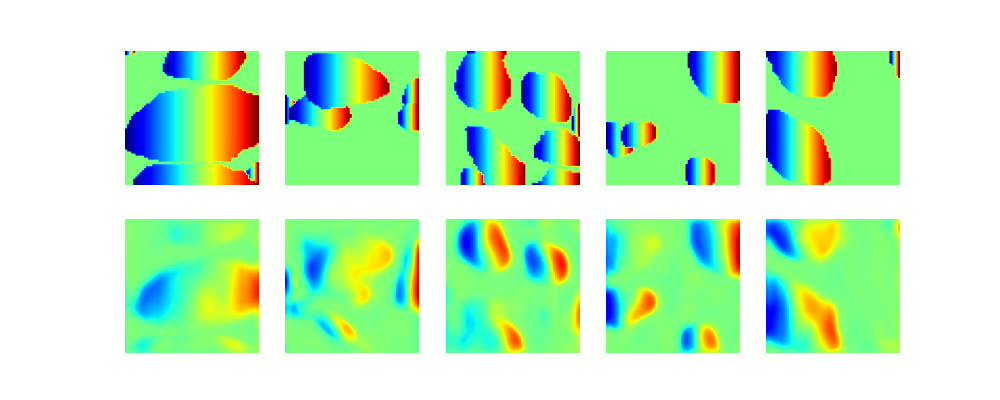

In [8]:
# DISPLAY
from src.vizualizations.image_viz import plot_images

h_maps = [img["hover_map"][0] for img in sample] + [img["hover_map"][0] for img in predictions]
plot_images(h_maps,(2,5),"jet",vmin=-1,vmax=1)

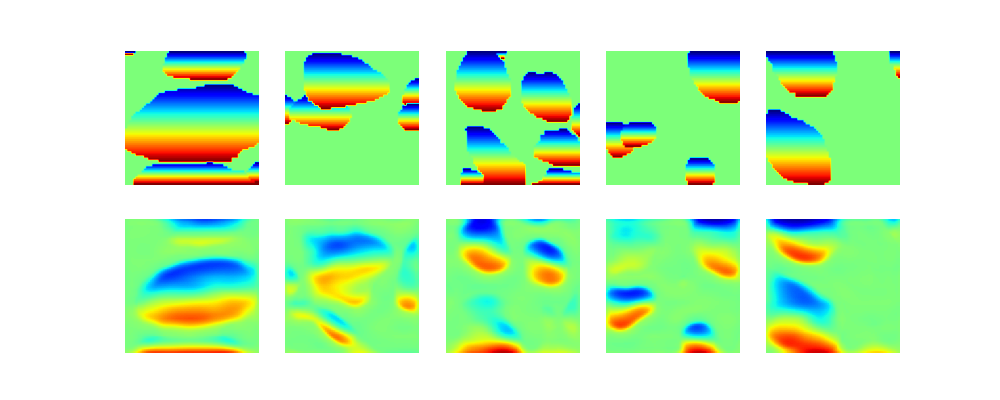

In [9]:
v_maps = [img["hover_map"][1] for img in sample] + [img["hover_map"][1] for img in predictions]
plot_images(v_maps,(2,5),"jet", vmin=-1,vmax=1)

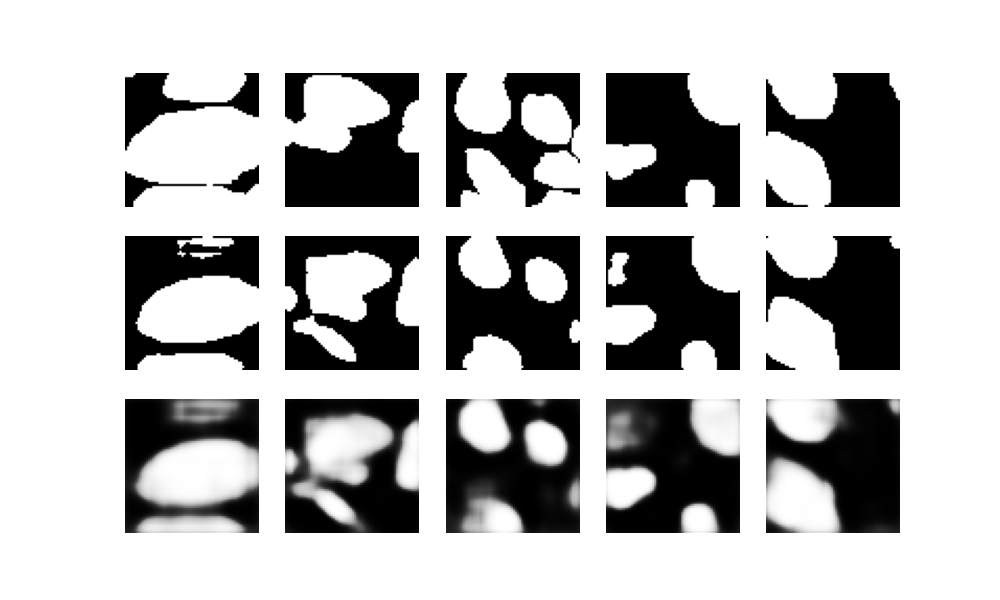

In [10]:
sms = [img["semantic_mask"].squeeze() for img in sample] + [img["semantic_mask_hard"] for img in predictions] + [img["semantic_mask"] for img in predictions]
plot_images(sms,(3,5),"gray")

# Filters
Here, I explore some image processing filters, such as the Sobel Filter for edge detection.

In [11]:
from PIL import ImageFilter
from torchvision.transforms import ToPILImage
from torch.nn.functional import conv2d
from torch import Tensor

sobel_x = Tensor([[-1,0,1],[-2,0,2],[-1,0,1]]).unsqueeze(0).unsqueeze(0).float()/4
sobel_y = Tensor([[1,2,1],[0,0,0],[-1,-2,-1]]).unsqueeze(0).unsqueeze(0).float()/4

def sobel(img):
    img = img.unsqueeze(0).unsqueeze(0)
    img_x = conv2d(img,sobel_x,stride=1,padding=1)
    img_y = conv2d(img,sobel_y,stride=1,padding=1)
    return img_x,img_y

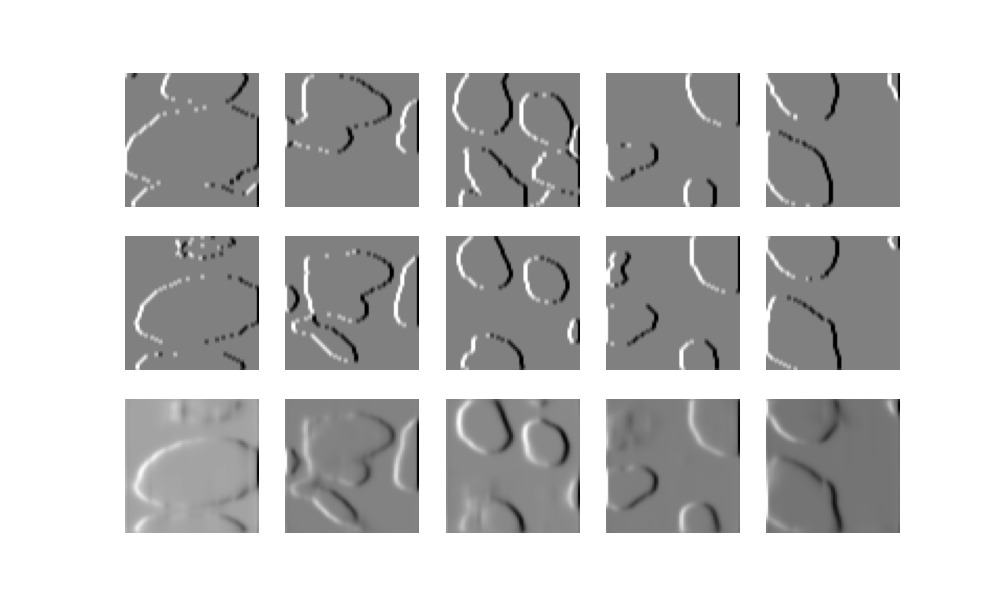

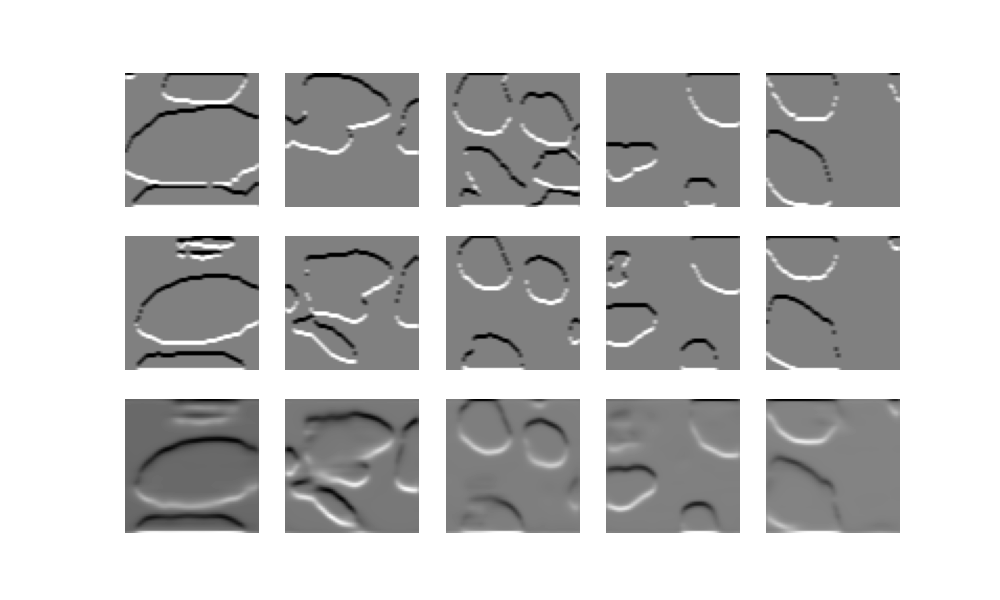

In [12]:
sms_sobel = [sobel(img.float()) for img in sms]
plot_images([img[0].squeeze() for img in sms_sobel],(3,5),"gray")
plot_images([img[1].squeeze() for img in sms_sobel],(3,5),"gray")

# TODO - NOTE THAT YOU NEED TO REALLY SPECIFY IN API USAGE


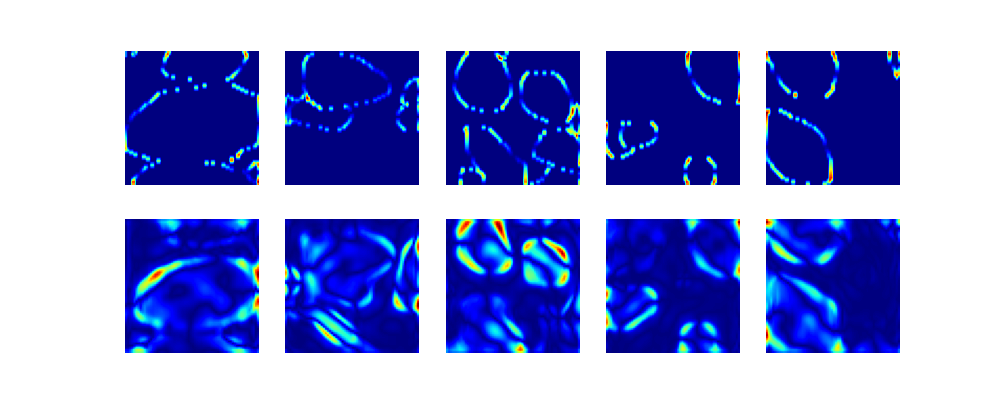

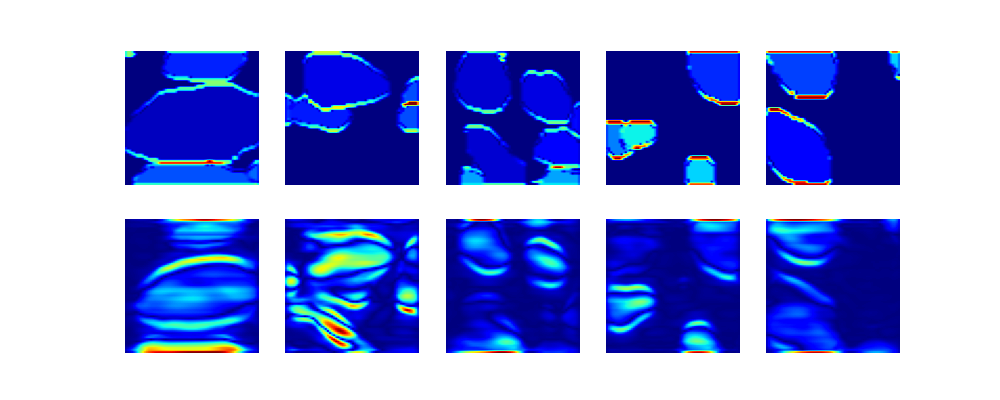

In [13]:
v_maps_sobel = [sobel(img.float()) for img in v_maps]
plot_images([img[0].squeeze().abs() for img in v_maps_sobel],(2,5),"jet")
plot_images([img[1].squeeze().abs() for img in v_maps_sobel],(2,5),"jet")

# you can see cells are 0 in first and non zero in second. This because horizontal grad perp to vertical

In [14]:
def S(hv_map):
    hv_horiz,hv_vert = hv_map
    hpx = sobel(hv_horiz.float())[0].abs()
    hpy = sobel(hv_vert.float())[1].abs()
    return torch.maximum(hpx,hpy).squeeze()

By looking at the sobel operator on the hover maps, we can start to see outlines of overlapping cells. On the top are the ground truth hover maps and on the bottom are predicted hovermaps. There are some intersting artefacts on the cells, making them look like loaves of bread.

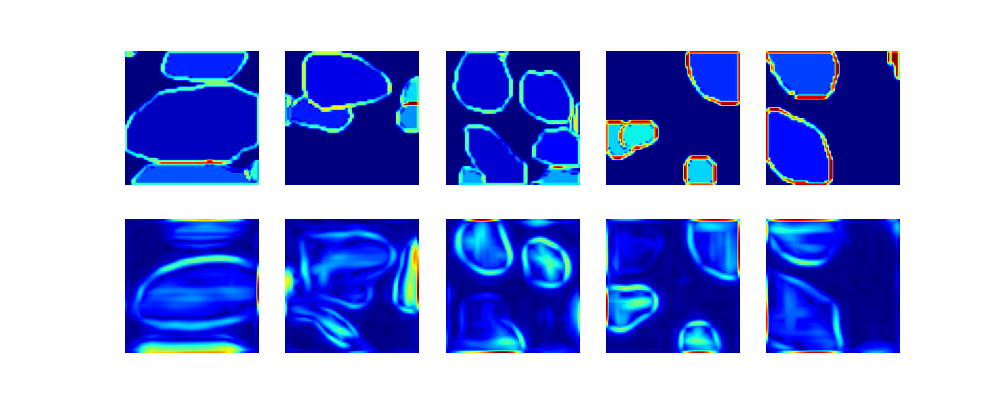

In [15]:
importance = [S(img) for img in zip(h_maps,v_maps)]
plot_images(importance,(2,5),"jet")

# Markers
Here, I follow the instructions to deriving the markers for water shedding

In [16]:
# Hyper parameters
h = 0.5
k = 0.3

In [17]:
def M(q,Sm):
    return torch.maximum(torch.zeros_like(q),(q>h).int()-(Sm>k).int())

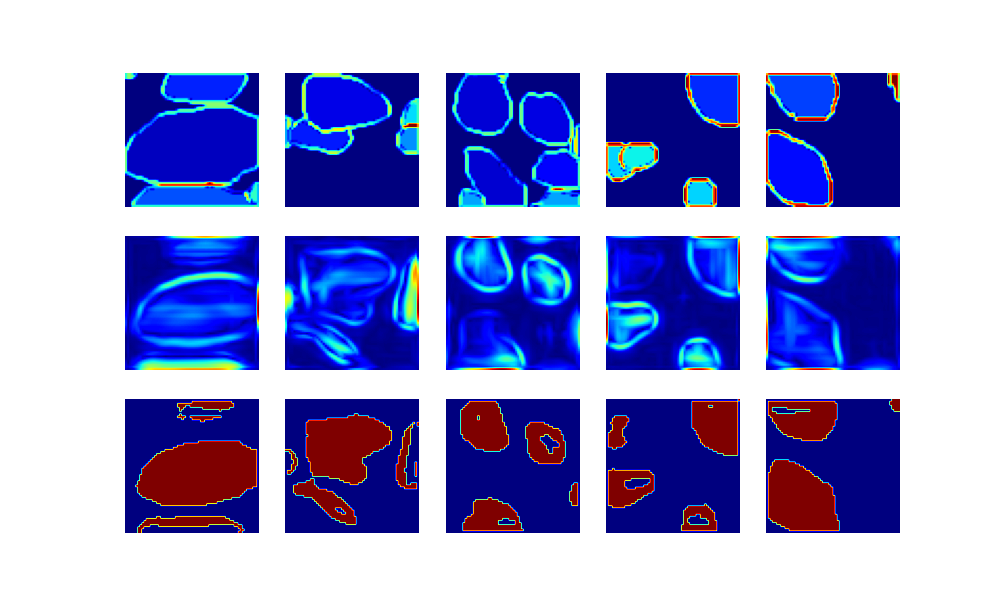

In [18]:
q_pred = sms[-5:]
Sm_pred = importance[-5:]
markers = [M(q,Sm) for q,Sm in zip(q_pred,Sm_pred)]
plot_images(importance+markers,(3,5),"jet")

# Energy Landscape

In [19]:
def E(q,Sm):
    return (1-(Sm>k).int())*(q>h).int()

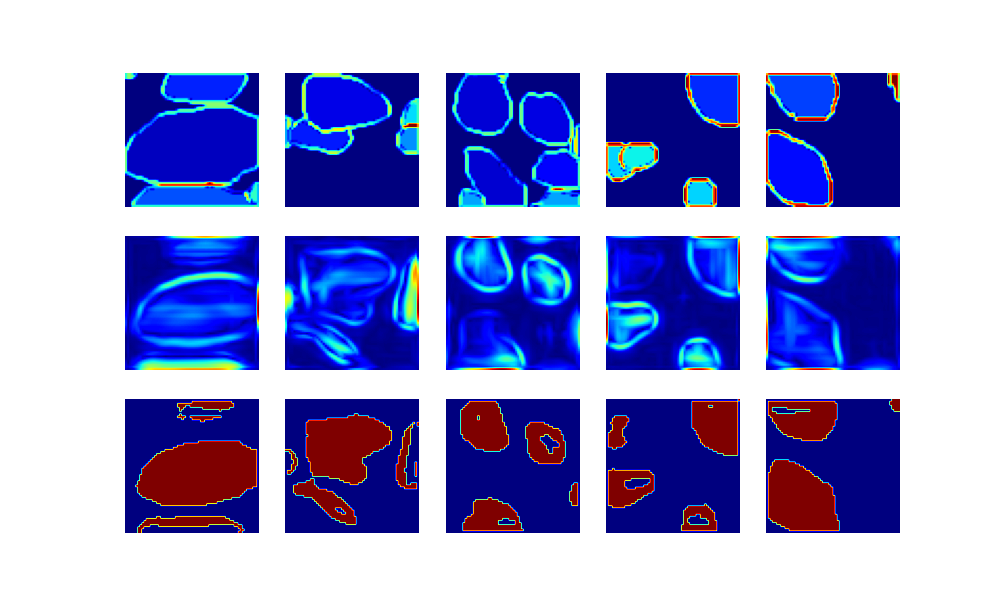

In [20]:
q_pred = sms[-5:]
Sm_pred = importance[-5:]
energy_landscape = [E(q,Sm) for q,Sm in zip(q_pred,Sm_pred)]
plot_images(importance+energy_landscape,(3,5),"jet")

# Watershedding
Here, I use watershedding with the energy landscape (the terrain) and the markers (proposed hills) to instance segment the image. On the top is the ground truth and on the bottom are the predictions

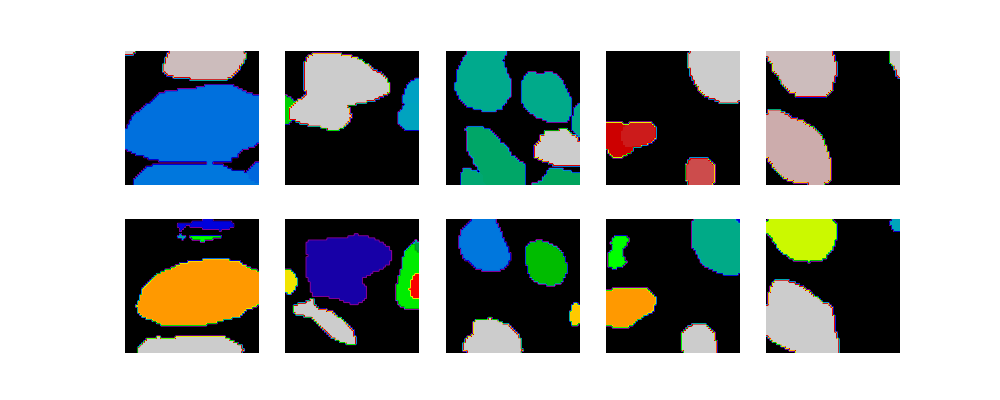

In [21]:
from skimage.segmentation import watershed
from skimage.feature.peak import peak_local_max
from scipy import ndimage
import numpy as np
def w_shed(dist:np.ndarray,mark:np.ndarray,mask:np.ndarray):
    
    lbs = ndimage.label(mark)[0]
    return watershed(-dist,markers= lbs, mask=mask) 


final_predictions = [w_shed(dist.numpy(),mark.numpy(),mask.numpy())for dist,mark,mask in zip(energy_landscape,markers,sms[5:10])]
plot_images([img["instance_mask"].squeeze() for img in sample] + final_predictions,(2,5))

# Metrics
Here, I look at the metrics used for evaluating the instance segmentation, incorrectly called Panoptic Quality by the paper i.m.o

In [22]:
from src.utilities.tensor_utilties import reset_ids
import numpy as np
from scipy.stats import mode

def IoU(img_1,img_2):
    p,s = (img_1*img_2).sum(),(img_1+img_2).sum()
    return p/(s-p)

def Panoptic_Quality(pred:np.ndarray,gt:np.ndarray):
    #TP = matched, FN = unmatched Ground Truth, FP = unmatched Predicted
    pred = reset_ids(pred)
    gt = reset_ids(gt)
    
    num_gt_cells = gt.max()
    num_pred_cells = pred.max()
    
    assignment_options = []
    
    gt_matched = set()
    pred_matched = set()
    
    TP = set()
    
    # 1) Find the predicted cell that overlaps the most with the ground truth cell
    for cell_id in range(1,num_gt_cells+1):
        gt_cell_mask = (gt==cell_id)
        mask_on_pred = (pred*gt_cell_mask)
        overlapped_ids = np.unique(mask_on_pred)
        assignment_options += [(cell_id,pred_id,IoU(gt_cell_mask.astype(np.int8),(pred==pred_id).astype(np.int8))) for pred_id in overlapped_ids if pred_id!=0]
        # (gt,pred,IoU)
    options_ranked = sorted(assignment_options,key=lambda triple: triple[2],reverse=True)

    # 2) Assign based on highest IoU (or just overlap?)
    
    for gt_id,pred_id,iou in options_ranked:
        if not(gt_id in gt_matched or pred_id in pred_matched):
            TP.add((gt_id,pred_id,iou))
            gt_matched.add(gt_id)
            pred_matched.add(pred_id)

    # 3) Collate into matched, unmatched gt, unmatched pred
    
    FP = set([i for i in range(1,num_pred_cells+1) if i not in pred_matched])
    FN = set([i for i in range(1,num_gt_cells+1) if i not in gt_matched])

    # 4) calculate panoptic quality
    
    DQ = len(TP)/(len(TP)+len(FP)/2+len(FN)/2)  # Detection Quality
    SQ=  sum([assig[2] for assig in TP])/len(TP)  # Segmentation Quality
       
    return DQ*SQ
gt = sample[0]["instance_mask"]
pred = final_predictions[0]
Panoptic_Quality(pred,gt.numpy())

0.3313903665234347

# Entire Pipeline
Putting it all together

In [23]:
# DATA
scale_modes = {"image": InterpolationMode.BILINEAR, "semantic_mask": InterpolationMode.NEAREST, "instance_map": InterpolationMode.NEAREST}
transforms = Compose([
        RandomCrop(size=(256, 256)),
        Normalize(
                {"image": [0.6441, 0.4474, 0.6039]},
                {"image": [0.1892, 0.1922, 0.1535]})
        ]) 
from src.datasets.MoNuSeg import MoNuSeg
val_folder=  os.path.join(parent,"data","processed","MoNuSeg_TRAIN")
dataset_val = MoNuSeg(val_folder,transform=transforms)


In [24]:
# PREDICTIONS
model.eval()
model.cpu()
ground_truth = []
predictions = []
for i in range(len(dataset_val)):
    item = dataset_val[i]
    sm,hv = model(item["image"].unsqueeze(0))
    sm = sm.squeeze().detach().cpu()
    hv = hv.squeeze().detach().cpu()
    predictions.append({"semantic_mask":sm,"hover_map":hv,"semantic_mask_hard":(sm>0.5).int()})
    ground_truth.append(item["instance_mask"])

In [25]:
def pipeline(prediction):
    q,Sm,mask = prediction["semantic_mask"],S(prediction["hover_map"]), prediction["semantic_mask_hard"]
    markers = M(q,Sm)
    energy = E(q,Sm)
    instance_mask = w_shed(energy.numpy(),markers.numpy(),mask.numpy())
    return instance_mask

predicted_instance_mask = [pipeline(pred) for pred in predictions]

In [26]:
pan_quality = [Panoptic_Quality(pred,gt.numpy()) for pred,gt in zip(predicted_instance_mask,ground_truth)]
print(sum(pan_quality)/len(pan_quality))

0.42672011424910233


# Visualization of the model's Stability
Here I simple explore predicting with a sliding window

In [27]:
import imageio
import io
import matplotlib.pyplot as plt
from src.utilities.img_utilities import tensor_to_numpy
from src.transforms.graph_construction.hover_maps import hover_map

def sliding_window_gif_example(sample,threshold=0.5,amplication=1,fps=10):
    model.eval()
    model.cuda()
    
    x_width = sample['image'].shape[2]
    f,ax=plt.subplots(2,4,figsize=(20,10))
    with imageio.get_writer("sliding_window_diagnosis.gif", mode='I', fps=fps) as writer:
        for x in tqdm(range(0,x_width-64,2)):
            
            cropped_image_orig = sample['image_original'][:,:64,x:x+64]
            cropped_image_trans = sample['image'][:,:64,x:x+64]
            cropped_sm_gt = sample['semantic_mask'].squeeze()[:64,x:x+64]
            ground_hv = hover_map(sample["instance_mask"][:,:64,x:x+64].squeeze())
            cropped_hv_x_gt = ground_hv[0]
            cropped_hv_y_gt = ground_hv[1]
            
            sm_pred,hv_map_pred = model(cropped_image_trans.unsqueeze(0).cuda())
            
            ax[0,0].imshow(tensor_to_numpy(cropped_image_orig.squeeze().detach().cpu()))
            ax[0,0].set_title("Original Image")
            ax[1,0].imshow(tensor_to_numpy(cropped_image_trans.squeeze().detach().cpu()))  
            ax[1,0].set_title("Transformed Image")
              
            ax[0,1].imshow(cropped_sm_gt.squeeze().detach().cpu().numpy(),cmap="gray",vmin=0,vmax=1)
            ax[0,1].set_title("Ground Truth Semantic Mask")
            ax[1,1].imshow((sm_pred.squeeze().detach().cpu()**amplication).numpy(),cmap="gray",vmin=0,vmax=1)
            ax[1,1].set_title(f"Predicted Semantic Mask Amplified by {amplication}")
            
            ax[0,2].imshow(cropped_hv_x_gt.squeeze().detach().cpu().numpy(),cmap="jet",vmin=-1,vmax=1)
            ax[0,2].set_title("Ground Truth Hover Map X")
            ax[1,2].imshow(hv_map_pred.squeeze()[0].detach().cpu().numpy(),cmap="jet",vmin=-1,vmax=1)
            ax[1,2].set_title("Predicted Hover Map X")
            
            ax[0,3].imshow(cropped_hv_y_gt.squeeze().detach().cpu().numpy(),cmap="jet",vmin=-1,vmax=1)
            ax[0,3].set_title("Ground Truth Hover Map Y")
            ax[1,3].imshow(hv_map_pred.squeeze()[1].detach().cpu().numpy(),cmap="jet",vmin=-1,vmax=1)
            ax[1,3].set_title("Predicted Hover Map Y")
            
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            plt_img = imageio.imread(buf)
            writer.append_data(plt_img)
ds_folder=  os.path.join(parent,"data","processed","MoNuSeg_TEST")
dataset = MoNuSeg(ds_folder,transform=transforms)
sliding_window_gif_example(dataset[0])
plt.close()


100%|██████████| 96/96 [03:06<00:00,  1.94s/it]


## Observations
- I am going to need to take care with the sliding window approach:
  - I am thinking of summing and averaging the crops. 
    - Would like to amplify the predictions (so predicting 1 vs 0.2 contributes more than 5x).
      - This amplifcation + the thresholds K and H can be grid searched
    - How do I then incorporate the hover map? Sum as well?


## Problem of HoverMap Creation
There is a problem at the moment regarding the hovermaps. A conundrum. A puzzler. The GT (Ground Truth) instance mask should be derived from the original image because then it reduces the number of weird artifacts (created because -1 and 1 is derived from bounding box which does not make sense when only part of the cell is visible); the original image is zoomed out. However, you also need to derive it after transformations as rotation, flipping etc will ruin the derivative and its direction etc.

**AS AN IDEA**:
1) Use larger images to train (not cropped as much) - cost of smaller batch sizes - why not then scale to compensate?
2) Crop to say 80, transform, calculate hover map, then crop down to 64 - cost of complexity as this flow does not fit into the existing pipeline (cannot interleave transform with calculation of the hovermap at the moment.)
3) Could estimate the bounding box through extrapolation - possibly inaccurate

# Concerns
- Energy and markers are the same?

# todos:
- [ ] Finetune h and k 
- [ ] Implement sliding window for re-construction of whole (metric can be on smaller)